<center>
<h1>Reinforcement Learning</h1>
<h1 style="color:blue">Defining & Solving RL Environments</h1>
</center>

## Squirrel Maze


In [ ]:
# import cv2
import gym as gym
from gym import spaces
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
import optuna


c:\Users\Kiyo\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Environment requirements:

- Min number of states: 12
- Min number of actions: 4
- Min number of rewards: 4

### About Environment

- Theme: Squirrel world, where Acorn's are the positive rewards, hunter is the -ve reward and reaching home is the goal.

- States: {S1 = (0,0), S2 = (0,1), S3 = (0,2), S4 = (0,3), S5 = (1,0), S6 = (1,1), S7 = (1,2), S8 = (1,3), S9 = (2,0), S10 = (2,1), S11 = (2,2), S12 = (2,3), S13 = (3,0), S14 = (3,1), S15 = (3,2), S16 = (3,3)}

- Actions: {Up, Down, Right, Left}

- Rewards: {-20, -50, +50, +80}

- Objective: Reach the goal state with maximum reward



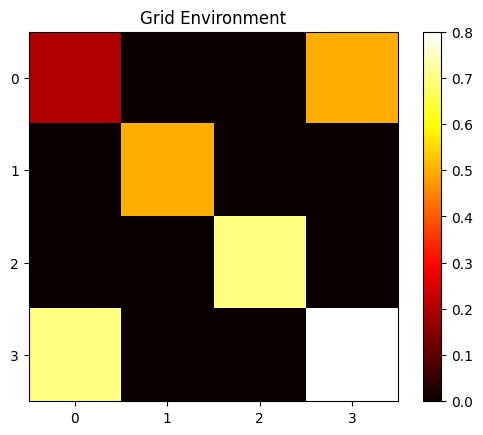

In [ ]:
# start position of our squirrel
pos1 = [0, 0]  

# goal position of our squirrel
pos2 = [3, 3]  

# Acorn positions
b1 = [0, 3]
b2 = [1, 1]

# Hunter positions
r1 = [2, 2]
r2 = [3, 0]

# Creating the grid
grid = np.zeros((4, 4))
grid[tuple(pos1)] = 0.2
grid[tuple(pos2)] = 0.8
grid[tuple(b1)] = 0.5
grid[tuple(b2)] = 0.5
grid[tuple(r1)] = 0.7
grid[tuple(r2)] = 0.7

# Display the grid
plt.imshow(grid,  cmap='hot',vmin=0)
plt.colorbar()
plt.xticks(np.arange(0, 4, 1))
plt.yticks(np.arange(0, 4, 1))
plt.gca().set_xticklabels(np.arange(0, 4, 1)) 
plt.gca().set_yticklabels(np.arange(0, 4, 1)) 
plt.title('Grid Environment')
plt.show()


###  1.1 Deterministic Environment - Run 10 timestamps

In [ ]:
class SquirrelPet(gym.Env):
    metadata = {'render.modes': []}

    def __init__(self, gamma=0.9, alpha=0.1, max_timestamp=10):
        self.gamma = gamma
        self.alpha = alpha

        self.obs_space = spaces.Discrete(16)
        self.action_space = spaces.Discrete(4)
        self.max_timestamp = max_timestamp
        self.timestep = 0
        self.state = np.zeros((4, 4))
        self.myagent = np.asarray([0, 0])
        self.goal_loc = np.asarray([3, 3])
        self.acorn_loc = [np.asarray([0, 3]), np.asarray([1,1])]
        self.hunter_loc = [np.asarray([2, 2]), np.asarray([3, 0])]

        self.state[tuple(self.myagent)] = 0.2
        self.state[tuple(self.goal_loc)] = 0.8
        for pos in self.acorn_loc:
            self.state[tuple(pos)] = 0.5
        for pos in self.hunter_loc:
            self.state[tuple(pos)] = 0.4

        self.prev_state = np.zeros((4, 4))  
        self.prev_action = None  
        self.flag_out = 0 
        self.penalty_counter = 0

    def reset(self, **kwargs):
        self.state = np.zeros((4, 4))
        self.myagent = np.asarray([0, 0])
        self.state[tuple(self.myagent)] = 0.2
        self.state[tuple(self.goal_loc)] = 0.8

        for pos in self.acorn_loc:
            self.state[tuple(pos)] = 0.5
        for pos in self.hunter_loc:
            self.state[tuple(pos)] = 0.4

        self.prev_state = np.zeros((4, 4))
        self.prev_action = None
        self.flag_out = 0 
        
        obs = self.state.flatten()
        self.timestep = 0
        info = {}
        self.penalty_counter = 0
        return obs, info

    def step(self, action):
        self.prev_state = np.copy(self.state)  
        self.prev_action = action  
        self.flag_out = 0  

        if action == 0:  
            self.myagent[0] += 1 #right
        elif action == 1:
            self.myagent[0] -= 1 #left
        elif action == 2:
            self.myagent[1] += 1 #up
        elif action == 3:
            self.myagent[1] -= 1 #down

        self.myagent = np.clip(self.myagent, 0, 3)

        # If the agent is in the same position as the previous step, choose a different action
        prev_state_positions = np.argwhere(self.prev_state == 0.2)
        if len(prev_state_positions) > 0 and np.array_equal(self.myagent, prev_state_positions[0]):
            while action == self.prev_action:
                action = self.action_space.sample()
            self.flag_out = 1

        self.state = np.zeros((4, 4))
        self.state[tuple(self.myagent)] = 0.2
        self.state[tuple(self.goal_loc)] = 0.8
        for pos in self.acorn_loc:
            self.state[tuple(pos)] = 0.5
        for pos in self.hunter_loc:
            self.state[tuple(pos)] = 0.4

        obs = self.state.flatten()
        reward = self.calculate_reward()
        penalty = any(np.array_equal(self.myagent, pos) for pos in self.hunter_loc)
        if penalty:
            self.penalty_counter += 1 
        self.timestep += 1

        terminated = True if np.array_equal(self.myagent, self.goal_loc) else self.timestep >= self.max_timestamp
        truncated = True if np.any((self.myagent < 0) | (self.myagent > 3)) else False
        if truncated:
            self.flag_out = 1  

        info = {}

        return self.state.flatten(), reward, terminated, truncated, info

    def calculate_reward(self):
        prev_myagentitions = np.argwhere(self.prev_state == 0.2)
        if prev_myagentitions.size == 0:
            prev_myagentition = self.myagent
        else:
            prev_myagentition = prev_myagentitions[0]

        # Calculating distance to goal before and after the step
        prev_distance_to_goal = np.linalg.norm(self.goal_loc - prev_myagentition)
        current_distance_to_goal = np.linalg.norm(self.goal_loc - self.myagent)

        if np.array_equal(self.myagent, self.goal_loc):
            reward = 10
        elif np.array_equal(self.myagent, self.hunter_loc[0]):
            reward = -20
        elif np.array_equal(self.myagent, self.hunter_loc[1]):
            reward = -50
        elif np.array_equal(self.myagent, self.acorn_loc[0]):
            reward = 50
        elif np.array_equal(self.myagent, self.acorn_loc[1]):
            reward = 80
        elif current_distance_to_goal < prev_distance_to_goal:
            reward = 10  # Positive reward for moving closer to goal
        elif current_distance_to_goal > prev_distance_to_goal:
            reward = -10  # Negative reward for moving away to goal
        else:
            reward = -5  # Slight negative reward for no change

        return reward

    def get_penalty_count(self):
        return self.penalty_counter

    def render(self):
        fig, ax = plt.subplots()
        plt.title('Grid Environment')

        #--------------Adding the background and grod lines for clarity

        # Set the background image
        background_img_path = '/Users/Kiyo/Desktop/RL/A1/images/Cartoon_green_texture_grass.jpg'  
        background_img = plt.imread(background_img_path)
        ax.imshow(background_img, extent=[-0.5, 3.5, -0.5, 3.5])

        # Drawing grey grid lines
        ax.grid(which='major', color='grey', linestyle='-', linewidth=0.5)
        ax.set_xticks(np.arange(-0.5, 4, 1))
        ax.set_yticks(np.arange(-0.5, 4, 1))

        # Ensure the grid is behind other plot elements
        ax.set_axisbelow(True)




        #------------------------------------------------------------

        agent_img = plt.imread('/Users/Kiyo/Desktop/RL/A1/images/squirrel.png')
        hunter_img = plt.imread('/Users/Kiyo/Desktop/RL/A1/images/hunter.png')
        acorn_img = plt.imread('/Users/Kiyo/Desktop/RL/A1/images/acorn.png')
        goal_img = plt.imread('/Users/Kiyo/Desktop/RL/A1/images/house.png')
        squirrel_hunters_boom_img = plt.imread('/Users/Kiyo/Desktop/RL/A1/images/squirrel_hunter.png')
        squirrel_acorn_bolt_img = plt.imread('/Users/Kiyo/Desktop/RL/A1/images/squirrel_acorn.jpg')
        squirrel_goal_win_img = plt.imread('/Users/Kiyo/Desktop/RL/A1/images/squirrel_house.jpg')
        squirrel_grid_cross_img = plt.imread('/Users/Kiyo/Desktop/RL/A1/images/squirrel_out.jpg')

        # Plot agent
        myagent = self.myagent
        if self.flag_out:
            agent_img = squirrel_grid_cross_img
        agent_box = AnnotationBbox(OffsetImage(agent_img, zoom=0.4), myagent, frameon=False)
        ax.add_artist(agent_box)

        # Plot hunters
        for hunter_loc in self.hunter_loc:
            hunter_loc = hunter_loc
            if np.array_equal(self.myagent, hunter_loc):
                hunter_img = squirrel_hunters_boom_img
            else:
                hunter_img = plt.imread('/Users/Kiyo/Desktop/RL/A1/images/hunter.png')
            hunter_box = AnnotationBbox(OffsetImage(hunter_img, zoom=0.4), hunter_loc, frameon=False)
            ax.add_artist(hunter_box)

        # Plot batteries
        for acorn_loc in self.acorn_loc:
            acorn_loc = acorn_loc
            if np.array_equal(self.myagent, acorn_loc):
                acorn_img = squirrel_acorn_bolt_img
            else:
                acorn_img = plt.imread('/Users/Kiyo/Desktop/RL/A1/images/acorn.png')
            acorn_box = AnnotationBbox(OffsetImage(acorn_img, zoom=0.4), acorn_loc, frameon=False)
            ax.add_artist(acorn_box)

        # Plot goal
        goal_loc = self.goal_loc
        goal_loc = self.goal_loc
        if np.array_equal(self.myagent, goal_loc):
            goal_img = squirrel_goal_win_img
        else:
            goal_img = plt.imread('/Users/Kiyo/Desktop/RL/A1/images/house.png')
        goal_box = AnnotationBbox(OffsetImage(goal_img, zoom=0.4), goal_loc, frameon=False)
        ax.add_artist(goal_box)

        plt.xticks(np.arange(-0.5, 4.5, 1))
        plt.yticks(np.arange(-0.5, 4.5, 1))
        plt.gca().set_xticklabels(np.arange(-0.5, 4.5, 1))
        plt.gca().set_yticklabels(np.arange(-0.5, 4.5, 1))
        plt.show()
        
    def obs_space_to_index(self, obs):
        """ Convert the agent's position to an integer index for the Q-table. """
        myagent = np.argwhere(obs.reshape(4, 4) == 0.2)
        if myagent.size == 0:
            return 0 
        return myagent[0, 0] * 4 + myagent[0, 1]
    


Step 1 - Action: 2, Reward: 10
Current State:
[[0.  0.2 0.  0.5]
 [0.  0.5 0.  0. ]
 [0.  0.  0.4 0. ]
 [0.4 0.  0.  0.8]]


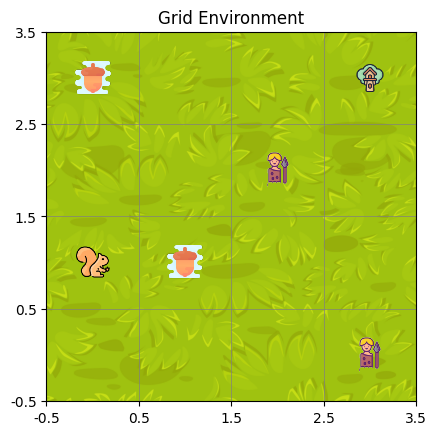

Step 2 - Action: 1, Reward: -5
Current State:
[[0.  0.2 0.  0.5]
 [0.  0.5 0.  0. ]
 [0.  0.  0.4 0. ]
 [0.4 0.  0.  0.8]]


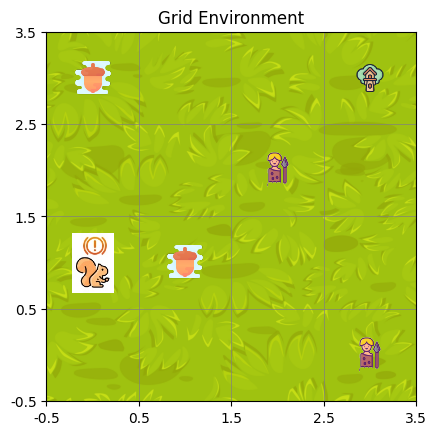

Step 3 - Action: 1, Reward: -5
Current State:
[[0.  0.2 0.  0.5]
 [0.  0.5 0.  0. ]
 [0.  0.  0.4 0. ]
 [0.4 0.  0.  0.8]]


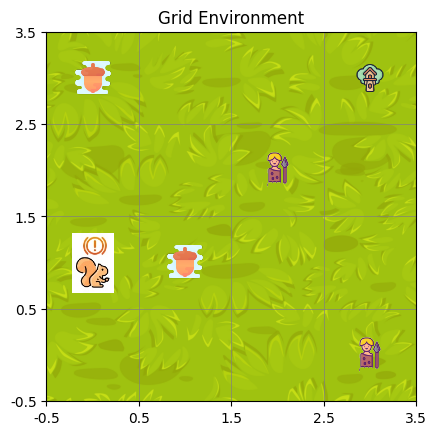

Step 4 - Action: 2, Reward: 10
Current State:
[[0.  0.  0.2 0.5]
 [0.  0.5 0.  0. ]
 [0.  0.  0.4 0. ]
 [0.4 0.  0.  0.8]]


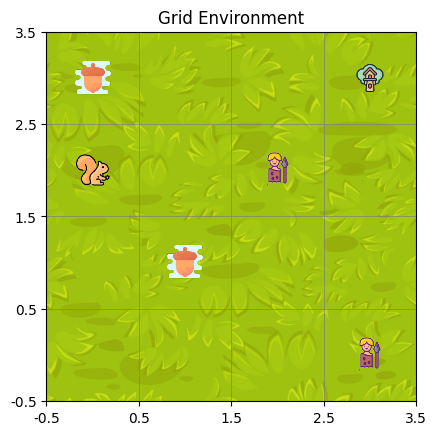

Step 5 - Action: 0, Reward: 10
Current State:
[[0.  0.  0.  0.5]
 [0.  0.5 0.2 0. ]
 [0.  0.  0.4 0. ]
 [0.4 0.  0.  0.8]]


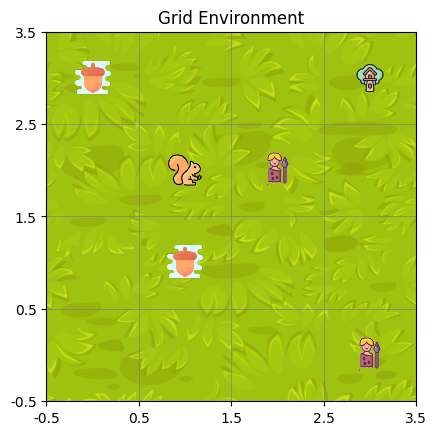

Step 6 - Action: 0, Reward: -20
Current State:
[[0.  0.  0.  0.5]
 [0.  0.5 0.  0. ]
 [0.  0.  0.4 0. ]
 [0.4 0.  0.  0.8]]


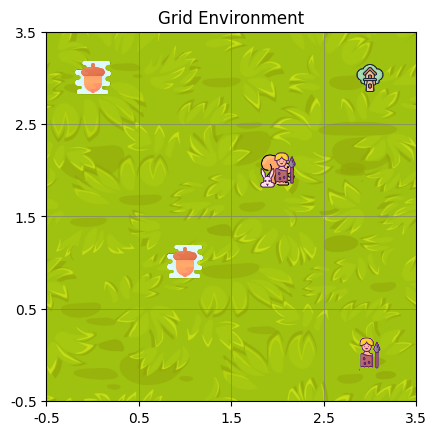

Step 7 - Action: 0, Reward: -5
Current State:
[[0.  0.  0.  0.5]
 [0.  0.5 0.  0. ]
 [0.  0.  0.4 0. ]
 [0.4 0.  0.2 0.8]]


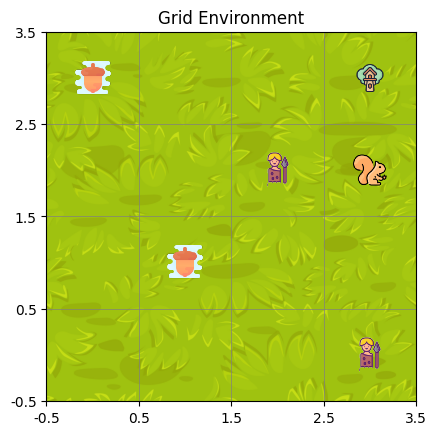

Step 8 - Action: 0, Reward: -5
Current State:
[[0.  0.  0.  0.5]
 [0.  0.5 0.  0. ]
 [0.  0.  0.4 0. ]
 [0.4 0.  0.2 0.8]]


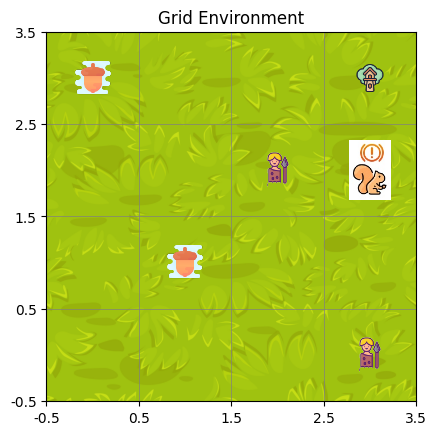

Step 9 - Action: 3, Reward: -10
Current State:
[[0.  0.  0.  0.5]
 [0.  0.5 0.  0. ]
 [0.  0.  0.4 0. ]
 [0.4 0.2 0.  0.8]]


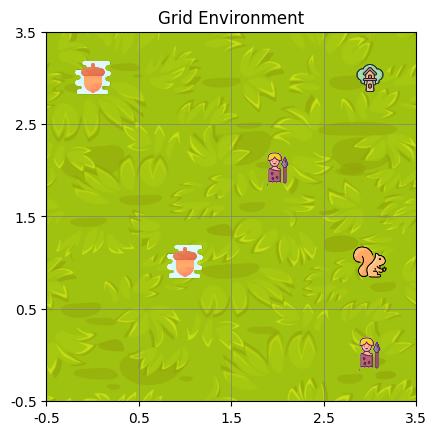

Step 10 - Action: 1, Reward: -10
Current State:
[[0.  0.  0.  0.5]
 [0.  0.5 0.  0. ]
 [0.  0.2 0.4 0. ]
 [0.4 0.  0.  0.8]]


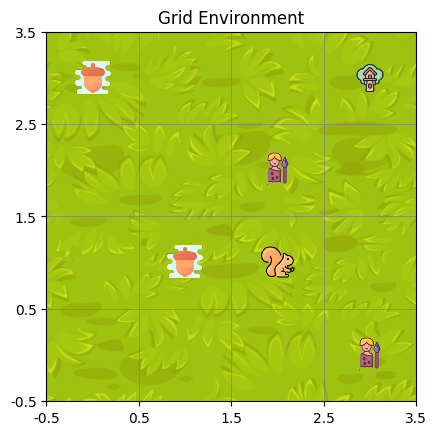

In [ ]:
env = SquirrelPet()
for _ in range(10):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    print(f"Step {_ + 1} - Action: {action}, Reward: {reward}")
    print("Current State:")
    print(env.state)
    env.render()

    # if terminated or truncated:
    #     print("Resetting environment due to termination or truncation.")
    #     obs = env.reset()
    if terminated or truncated:
        env.state = np.copy(env.prev_state) 
        env.myagent = np.argwhere(env.state == 0.2)[0]


###  1.2 Stochastic Environment - Run 10 timestamps

- He're iam bringing randomness to the the agent's movement. Instead of the agent moving deterministically based on the action chosen, with the probability that the agent moves in a different direction than intended.
- CHanges are done at the step function to acheivethe following

In [ ]:
class SquirrelPet_stoch(gym.Env):
    metadata = {'render.modes': []}

    def __init__(self, gamma=0.9, alpha=0.1, max_timestamp=10):
        self.gamma = gamma
        self.alpha = alpha

        self.obs_space = spaces.Discrete(16)
        self.action_space = spaces.Discrete(4)
        self.max_timestamp = max_timestamp
        self.timestep = 0
        self.state = np.zeros((4, 4))
        self.myagent = np.asarray([0, 0])
        self.goal_loc = np.asarray([3, 3])
        self.acorn_loc = [np.asarray([0, 3]), np.asarray([1,1])]
        self.hunter_loc = [np.asarray([2, 2]), np.asarray([3, 0])]

        self.state[tuple(self.myagent)] = 0.2
        self.state[tuple(self.goal_loc)] = 0.8
        for pos in self.acorn_loc:
            self.state[tuple(pos)] = 0.5
        for pos in self.hunter_loc:
            self.state[tuple(pos)] = 0.4

        self.prev_state = np.zeros((4, 4))  
        self.prev_action = None  
        self.flag_out = 0 
        self.penalty_counter = 0

    def reset(self, **kwargs):
        self.state = np.zeros((4, 4))
        self.myagent = np.asarray([0, 0])
        self.state[tuple(self.myagent)] = 0.2
        self.state[tuple(self.goal_loc)] = 0.8

        for pos in self.acorn_loc:
            self.state[tuple(pos)] = 0.5
        for pos in self.hunter_loc:
            self.state[tuple(pos)] = 0.4

        self.prev_state = np.zeros((4, 4))
        self.prev_action = None
        self.flag_out = 0 
        
        obs = self.state.flatten()
        self.timestep = 0
        info = {}
        self.penalty_counter = 0
        return obs, info

# bring the randomeness to the agenet moments
    
    def step(self, action):
        self.prev_state = np.copy(self.state)  
        self.prev_action = action  
        self.flag_out = 0  

        action_probabilities = {
            0: [0.7, 0.1, 0.1, 0.1],  # Probabilities for action 0: 70% Right, 10% rest
            1: [0.1, 0.7, 0.1, 0.1],  # Probabilities for action 1: 70% Left, 10% rest
            2: [0.1, 0.1, 0.7, 0.1],  # Probabilities for action 2: 70% Up, 10% rest
            3: [0.1, 0.1, 0.1, 0.7],  # Probabilities for action 3: 70% Down, 10% rest
        }

        # Select the actual action based on the probability distribution for the intended action
        actual_action = np.random.choice([0, 1, 2, 3], p=action_probabilities[action])

        print(f"Requested Action: {action}, Chosen Action: {actual_action}")

        # Execute the actual action
        if actual_action == 0:
            self.myagent[0] += 1  # Right
        elif actual_action == 1:
            self.myagent[0] -= 1  # left
        elif actual_action == 2:
            self.myagent[1] += 1  # Up
        elif actual_action == 3:
            self.myagent[1] -= 1  # Down
            

        self.myagent = np.clip(self.myagent, 0, 3)

        # If the agent is in the same position as the previous step, choose a different action
        prev_state_positions = np.argwhere(self.prev_state == 0.2)
        if len(prev_state_positions) > 0 and np.array_equal(self.myagent, prev_state_positions[0]):
            while action == self.prev_action:
                action = self.action_space.sample()
            self.flag_out = 1

        self.state = np.zeros((4, 4))
        self.state[tuple(self.myagent)] = 0.2
        self.state[tuple(self.goal_loc)] = 0.8
        for pos in self.acorn_loc:
            self.state[tuple(pos)] = 0.5
        for pos in self.hunter_loc:
            self.state[tuple(pos)] = 0.4

        obs = self.state.flatten()
        reward = self.calculate_reward()
        penalty = any(np.array_equal(self.myagent, pos) for pos in self.hunter_loc)
        if penalty:
            self.penalty_counter += 1 
        self.timestep += 1

        terminated = True if np.array_equal(self.myagent, self.goal_loc) else self.timestep >= self.max_timestamp
        truncated = True if np.any((self.myagent < 0) | (self.myagent > 3)) else False
        if truncated:
            self.flag_out = 1  

        info = {}

        return self.state.flatten(), reward, terminated, truncated, info

    def calculate_reward(self):
        prev_myagentitions = np.argwhere(self.prev_state == 0.2)
        if prev_myagentitions.size == 0:
            prev_myagentition = self.myagent
        else:
            prev_myagentition = prev_myagentitions[0]

        # Calculating distance to goal before and after the step
        prev_distance_to_goal = np.linalg.norm(self.goal_loc - prev_myagentition)
        current_distance_to_goal = np.linalg.norm(self.goal_loc - self.myagent)

        if np.array_equal(self.myagent, self.goal_loc):
            reward = 10
        elif np.array_equal(self.myagent, self.hunter_loc[0]):
            reward = -20
        elif np.array_equal(self.myagent, self.hunter_loc[1]):
            reward = -50
        elif np.array_equal(self.myagent, self.acorn_loc[0]):
            reward = 50
        elif np.array_equal(self.myagent, self.acorn_loc[1]):
            reward = 80
        elif current_distance_to_goal < prev_distance_to_goal:
            reward = 10  # Positive reward for moving closer to goal
        elif current_distance_to_goal > prev_distance_to_goal:
            reward = -10  # Negative reward for moving away to goal
        else:
            reward = -5  # Slight negative reward for no change

        return reward

    def get_penalty_count(self):
        return self.penalty_counter

    def render(self):
        fig, ax = plt.subplots()
        plt.title('Grid Environment')

        #--------------Adding the background and grod lines for clarity

        # Set the background image
        background_img_path = '/Users/Kiyo/Desktop/RL/A1/images/Cartoon_green_texture_grass.jpg'  
        background_img = plt.imread(background_img_path)
        ax.imshow(background_img, extent=[-0.5, 3.5, -0.5, 3.5])

        # Drawing grey grid lines
        ax.grid(which='major', color='grey', linestyle='-', linewidth=0.5)
        ax.set_xticks(np.arange(-0.5, 4, 1))
        ax.set_yticks(np.arange(-0.5, 4, 1))

        # Ensure the grid is behind other plot elements
        ax.set_axisbelow(True)




        #------------------------------------------------------------

        agent_img = plt.imread('/Users/Kiyo/Desktop/RL/A1/images/squirrel.png')
        hunter_img = plt.imread('/Users/Kiyo/Desktop/RL/A1/images/hunter.png')
        acorn_img = plt.imread('/Users/Kiyo/Desktop/RL/A1/images/acorn.png')
        goal_img = plt.imread('/Users/Kiyo/Desktop/RL/A1/images/house.png')
        squirrel_hunters_boom_img = plt.imread('/Users/Kiyo/Desktop/RL/A1/images/squirrel_hunter.png')
        squirrel_acorn_bolt_img = plt.imread('/Users/Kiyo/Desktop/RL/A1/images/squirrel_acorn.jpg')
        squirrel_goal_win_img = plt.imread('/Users/Kiyo/Desktop/RL/A1/images/squirrel_house.jpg')
        squirrel_grid_cross_img = plt.imread('/Users/Kiyo/Desktop/RL/A1/images/squirrel_out.jpg')

        # Plot agent
        myagent = self.myagent
        if self.flag_out:
            agent_img = squirrel_grid_cross_img
        agent_box = AnnotationBbox(OffsetImage(agent_img, zoom=0.4), myagent, frameon=False)
        ax.add_artist(agent_box)

        # Plot hunters
        for hunter_loc in self.hunter_loc:
            hunter_loc = hunter_loc
            if np.array_equal(self.myagent, hunter_loc):
                hunter_img = squirrel_hunters_boom_img
            else:
                hunter_img = plt.imread('/Users/Kiyo/Desktop/RL/A1/images/hunter.png')
            hunter_box = AnnotationBbox(OffsetImage(hunter_img, zoom=0.4), hunter_loc, frameon=False)
            ax.add_artist(hunter_box)

        # Plot batteries
        for acorn_loc in self.acorn_loc:
            acorn_loc = acorn_loc
            if np.array_equal(self.myagent, acorn_loc):
                acorn_img = squirrel_acorn_bolt_img
            else:
                acorn_img = plt.imread('/Users/Kiyo/Desktop/RL/A1/images/acorn.png')
            acorn_box = AnnotationBbox(OffsetImage(acorn_img, zoom=0.4), acorn_loc, frameon=False)
            ax.add_artist(acorn_box)

        # Plot goal
        goal_loc = self.goal_loc
        goal_loc = self.goal_loc
        if np.array_equal(self.myagent, goal_loc):
            goal_img = squirrel_goal_win_img
        else:
            goal_img = plt.imread('/Users/Kiyo/Desktop/RL/A1/images/house.png')
        goal_box = AnnotationBbox(OffsetImage(goal_img, zoom=0.4), goal_loc, frameon=False)
        ax.add_artist(goal_box)

        plt.xticks(np.arange(-0.5, 4.5, 1))
        plt.yticks(np.arange(-0.5, 4.5, 1))
        plt.gca().set_xticklabels(np.arange(-0.5, 4.5, 1))
        plt.gca().set_yticklabels(np.arange(-0.5, 4.5, 1))
        plt.show()
        
    def obs_space_to_index(self, obs):
        """ Convert the agent's position to an integer index for the Q-table. """
        myagent = np.argwhere(obs.reshape(4, 4) == 0.2)
        if myagent.size == 0:
            return 0 
        return myagent[0, 0] * 4 + myagent[0, 1]
    


Requested Action: 0, Chosen Action: 0
Step 1 - Action: 0, Reward: 10
Current State:
[[0.  0.  0.  0.5]
 [0.2 0.5 0.  0. ]
 [0.  0.  0.4 0. ]
 [0.4 0.  0.  0.8]]


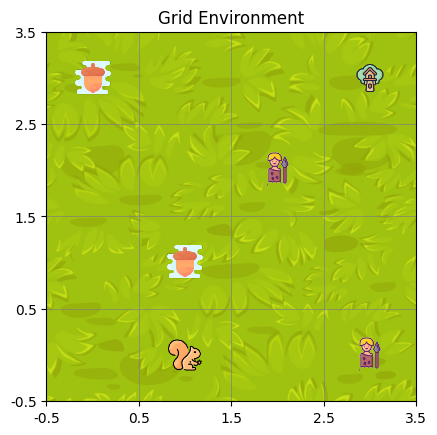

Requested Action: 2, Chosen Action: 1
Step 2 - Action: 2, Reward: -10
Current State:
[[0.2 0.  0.  0.5]
 [0.  0.5 0.  0. ]
 [0.  0.  0.4 0. ]
 [0.4 0.  0.  0.8]]


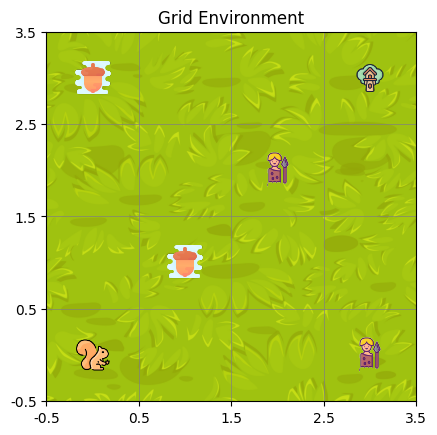

Requested Action: 1, Chosen Action: 1
Step 3 - Action: 1, Reward: -5
Current State:
[[0.2 0.  0.  0.5]
 [0.  0.5 0.  0. ]
 [0.  0.  0.4 0. ]
 [0.4 0.  0.  0.8]]


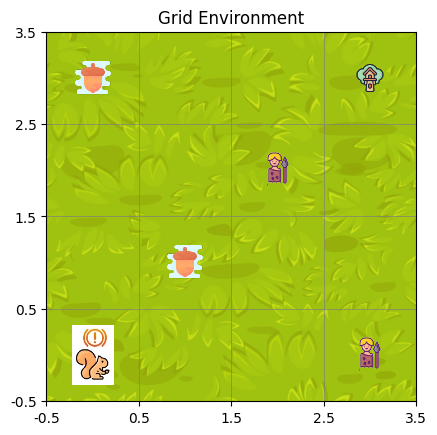

Requested Action: 1, Chosen Action: 1
Step 4 - Action: 1, Reward: -5
Current State:
[[0.2 0.  0.  0.5]
 [0.  0.5 0.  0. ]
 [0.  0.  0.4 0. ]
 [0.4 0.  0.  0.8]]


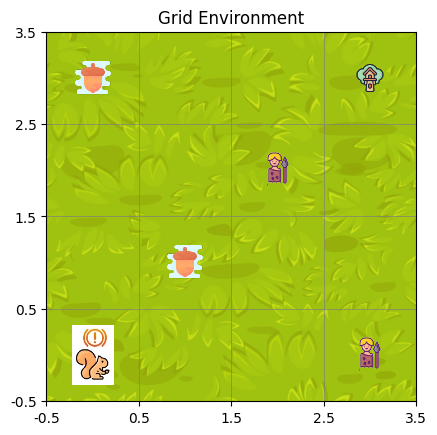

Requested Action: 2, Chosen Action: 2
Step 5 - Action: 2, Reward: 10
Current State:
[[0.  0.2 0.  0.5]
 [0.  0.5 0.  0. ]
 [0.  0.  0.4 0. ]
 [0.4 0.  0.  0.8]]


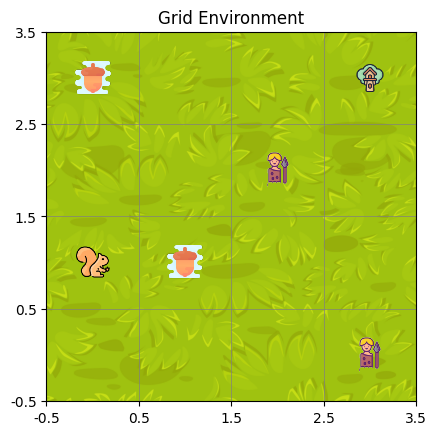

Requested Action: 0, Chosen Action: 0
Step 6 - Action: 0, Reward: 80
Current State:
[[0.  0.  0.  0.5]
 [0.  0.5 0.  0. ]
 [0.  0.  0.4 0. ]
 [0.4 0.  0.  0.8]]


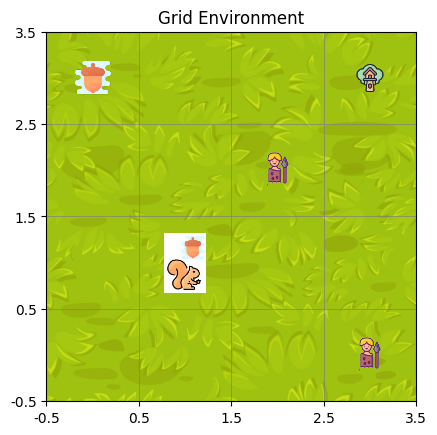

Requested Action: 1, Chosen Action: 1
Step 7 - Action: 1, Reward: -5
Current State:
[[0.  0.2 0.  0.5]
 [0.  0.5 0.  0. ]
 [0.  0.  0.4 0. ]
 [0.4 0.  0.  0.8]]


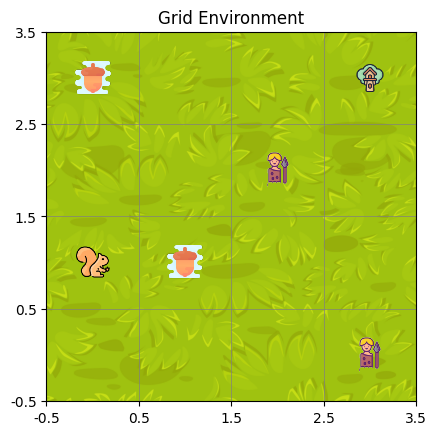

Requested Action: 1, Chosen Action: 1
Step 8 - Action: 1, Reward: -5
Current State:
[[0.  0.2 0.  0.5]
 [0.  0.5 0.  0. ]
 [0.  0.  0.4 0. ]
 [0.4 0.  0.  0.8]]


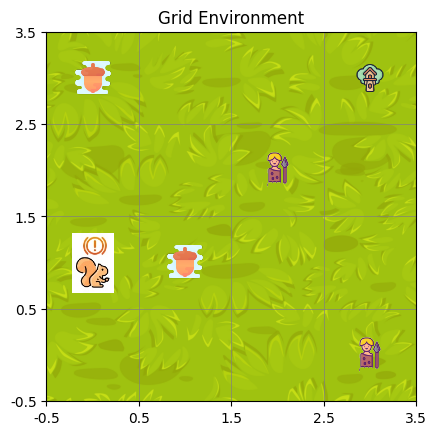

Requested Action: 2, Chosen Action: 2
Step 9 - Action: 2, Reward: 10
Current State:
[[0.  0.  0.2 0.5]
 [0.  0.5 0.  0. ]
 [0.  0.  0.4 0. ]
 [0.4 0.  0.  0.8]]


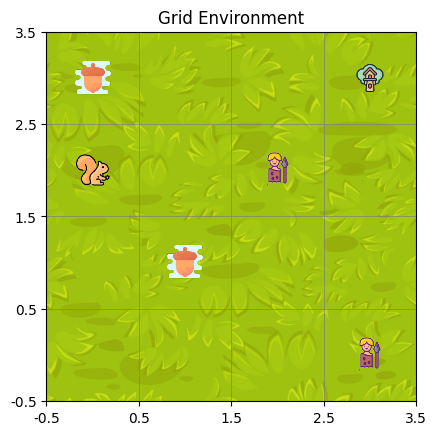

Requested Action: 0, Chosen Action: 3
Step 10 - Action: 0, Reward: -10
Current State:
[[0.  0.2 0.  0.5]
 [0.  0.5 0.  0. ]
 [0.  0.  0.4 0. ]
 [0.4 0.  0.  0.8]]


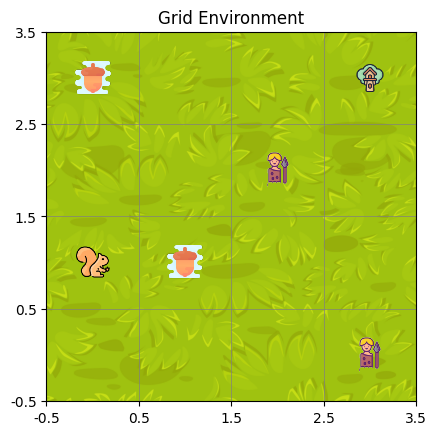

Resetting environment due to termination or truncation.


In [ ]:
env = SquirrelPet_stoch()  # Ensure this is the correct class name
for _ in range(10):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    print(f"Step {_ + 1} - Action: {action}, Reward: {reward}")
    print("Current State:")
    print(env.state)
    env.render()  # Temporarily commented out for brevity

    if terminated or truncated:
        print("Resetting environment due to termination or truncation.")
        obs = env.reset()  # Use env.reset() to correctly reset the environment
